In [1]:
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
# !pip install scikit_learn==0.24.2

In [3]:
print(sklearn.__version__)

0.24.2


In [4]:
df = pd.read_csv('../../data/models/df_featurize.csv')
df.head(3)

,trail_id,length,elevation_gain,route_type_out_and_back,route_type_point_to_point,features_ada,features_beach,features_cave,features_city_walk,features_dogs,...,activities_scenic_driving,activities_sea_kayaking,activities_skiing,activities_snowboarding,activities_snowshoeing,activities_surfing,activities_trail_running,activities_walking,activities_whitewater_kayaking,difficulty_class
0,10020048,8.87,1161.8976,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,hard
1,10236086,3.93,507.7968,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,moderate
2,10267857,1.65,81.9912,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,easy


# Train random forest model

In [5]:
def train(trail_id, response, test_size, random_state_split, random_state_model, model_path, x_test_path, y_test_path):
    
    # Train, test, split
    X = df.drop(columns=[response, trail_id], axis=1)
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state_split)

    # Train the model
    clf = RandomForestClassifier(random_state=random_state_model, n_estimators=10)
    clf = clf.fit(X_train, y_train)

    # Save the model
    pickle.dump(clf, open(model_path, 'wb'))

    # Save the test features and labels
    np.savetxt(x_test_path, X_test, delimiter=",", fmt='%s')
    np.savetxt(y_test_path, y_test, delimiter=",", fmt='%s')

# Evaluate cross validated accuracy

In [6]:
def evaluate(cv, model_path, x_test_path, y_test_path, scoring, cm_labels, output_path):
    # Load model, x_test, and y_test
    clf = pickle.load(open(model_path, 'rb'))
    X_test = pd.read_csv(x_test_path, sep=',')
    y_test = pd.read_csv(y_test_path, sep=',').values.ravel()

    # Get predictions and probabilities
    ypred_proba_test = clf.predict_proba(X_test)[:, 1]
    ypred_bin_test = clf.predict(X_test)

    # Calculate evaluation metrics
    cv_score = cross_val_score(clf, X_test, y_test, cv=cv, scoring=scoring)
    confusion = confusion_matrix(y_test, ypred_bin_test, labels=cm_labels)

    print('Mean CV score: {:.3f}'.format(cv_score.mean()))
    print('Var CV score  {:.3f}'.format(cv_score.std()))
    print()
    print(pd.DataFrame(confusion,
                       index=cm_labels,
                       columns=cm_labels))

    # Save results to a text file
    f = open(output_path, "w+")
    f.write('Mean CV score: {:.3f}'.format(cv_score.mean()))
    f.write('Var CV score  {:.3f}'.format(cv_score.std()))
    f.write('\n')
    f.write(pd.DataFrame(confusion,
                   index=cm_labels,
                   columns=cm_labels).to_string())
    f.close()

# Train and evaluate model

In [7]:
trail_id = 'trail_id'
response = 'difficulty_class'
test_size = 0.2
random_state_split = 0
random_state_model = 0
model_path = '../../models/model.pkl'
x_test_path = '../../data/models/x_test.csv'
y_test_path = '../../data/models/y_test.csv'

cv = 5
model_path = '../../models/model.pkl'
x_test_path = '../../data/models/x_test.csv'
y_test_path = '../../data/models/y_test.csv'
scoring = 'accuracy'
cm_labels = ['easy', 'moderate', 'hard']
output_path = '../../models/evaluate.txt'

In [8]:
train(trail_id, response, test_size, random_state_split, random_state_model, model_path, x_test_path, y_test_path)
evaluate(cv, model_path, x_test_path, y_test_path, scoring, cm_labels, output_path)

Mean CV score: 0.780
Var CV score  0.048

          easy  moderate  hard
easy       128        25     4
moderate    44       203    32
hard         0        36   186


In [10]:
clf = pickle.load(open('../../models/model.pkl', 'rb'))
clf

RandomForestClassifier(n_estimators=10, random_state=0)

In [16]:
X = df.drop(columns=['difficulty_class', 'trail_id'], axis=1)

In [18]:
for name, importance in zip(X.columns, clf.feature_importances_):
    print(name, importance)

length 0.14124896856360383
elevation_gain 0.26425064347535765
route_type_out_and_back 0.017355404155748627
route_type_point_to_point 0.006086717488026481
features_ada 0.006968049461094371
features_beach 0.005582549604440789
features_cave 0.004626017616670479
features_city_walk 0.00010899524298894363
features_dogs 0.0011638449822531068
features_dogs_leash 0.008917601002316996
features_dogs_no 0.014977663739796629
features_forest 0.01769935581137977
features_historic_site 0.004991011998119865
features_hot_springs 0.003942490553753909
features_kids 0.10627854260221156
features_lake 0.01578778852920763
features_partially_paved 0.006851509118187711
features_paved 0.003806749672110833
features_rails_trails 0.00035992332796277527
features_river 0.013151145876186926
features_strollers 0.004144859806702067
features_views 0.00948837100973737
features_waterfall 0.010355352925820908
features_wild_flowers 0.019895743272441625
features_wildlife 0.016704993909136392
activities_backpacking 0.025765009

In [19]:
imp_df = pd.DataFrame({'feature':X.columns, 'imp':clf.feature_importances_})
imp_df = imp_df.sort_values(by=['imp'],ascending=False).reset_index(drop=True)

In [26]:
imp_df.head(5)

,feature,imp
0,elevation_gain,0.264251
1,length,0.141249
2,activities_walking,0.131560
3,features_kids,0.106279
4,activities_backpacking,0.025765


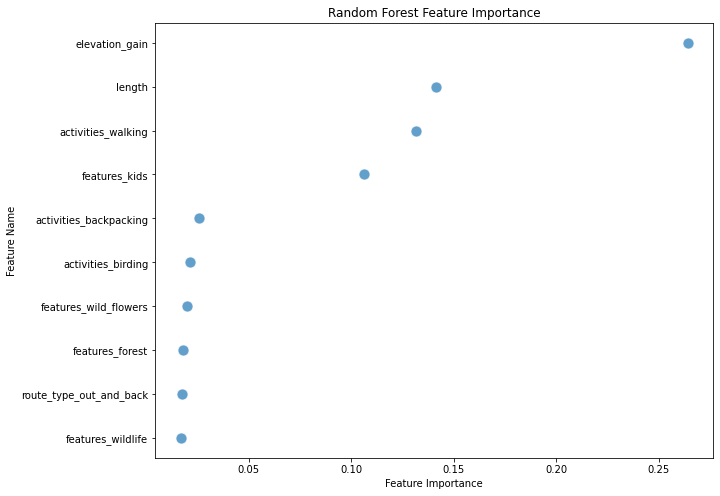

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,8))
sns.scatterplot(x='imp',y='feature',data=imp_df.head(10), marker='o', s=120, alpha=0.7)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Feature Importance')
plt.show()